In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np

# import os
# import sys
# sys.path.insert(0, os.path.abspath('/home/gaspar/git/pyha'))

# Overview
Moving average is useful construct:

- It is a matched filter for rectangular pulses
- Cheap low pass filter
- DC/bias removal applications

# Model
Moving average filter can be implemented as a FIR filter, here is an example for
window length of 4.

In [2]:
window_len = 8
taps = [1 / window_len] * window_len
taps

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

To demonstrate the effect of this filter lets make a noisy sine wave and use the filer on it:

# Noise reduction

In [3]:
def mavg(inputs, alen):
    taps = [1 / alen] * alen
    ret = np.convolve(inputs, taps, mode='full')
    return ret

<IPython.core.display.Javascript object>


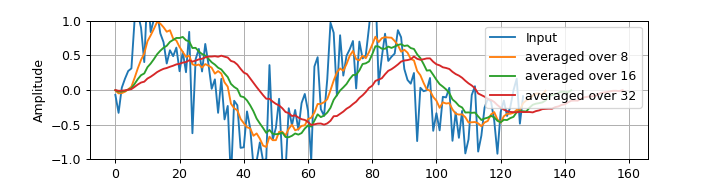

In [41]:
x = np.linspace(0,2*2*np.pi,128)
y = 0.6*np.sin(x)
noise = 0.4*np.random.normal(size=128)
y += noise

avg8 = mavg(y, 8)
avg16 = mavg(y, 16)
avg32 = mavg(y, 32)

plt.figure(figsize=(8, 2))
plt.plot(y, label='Input')
plt.plot(avg8, label='averaged over 8')
plt.plot(avg16, label='averaged over 16')
plt.plot(avg32, label='averaged over 32')

plt.legend()
plt.grid()
plt.ylim([-1, 1])
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.savefig('img/moving_average_noise.png', bbox_inches='tight')
plt.show()

# Match filtering

<IPython.core.display.Javascript object>


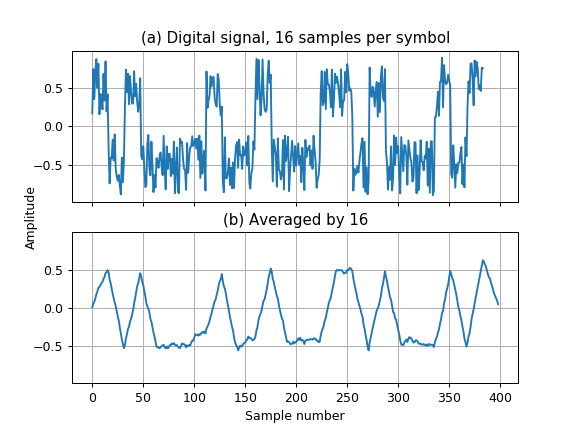

In [43]:
from pyhacores.under_construction.clock_recovery.test_ import data_gen
from pyha.common.util import hex_to_bool_list, bools_to_bitstr, hex_to_bitstr
sps = 16
noise_amp = 0.8
bits = hex_to_bool_list('a12345')
nrz = [[1] * sps if x else [-1] * sps for x in bits]
nrz = np.array(nrz).flatten()

# noise
sig = nrz + np.random.uniform(-noise_amp, noise_amp, len(nrz))

sig *= 0.5

o = mavg(sig, sps)
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
axes[0].plot(sig, label='signal')
axes[0].set_title('(a) Digital signal, 16 samples per symbol')
axes[0].grid()

axes[1].plot(o)
axes[1].set_title('(b) Averaged by 16')
axes[1].grid()

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.savefig('moving_average_matched.png', bbox_inches='tight')

plt.show()

# Freq domain

<IPython.core.display.Javascript object>


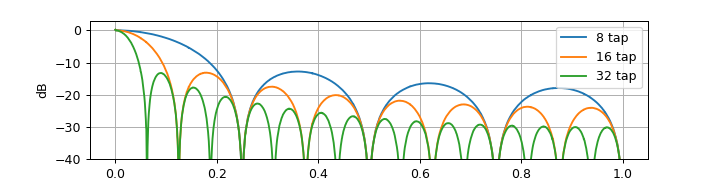

In [46]:
# https://se.mathworks.com/matlabcentral/newsreader/view_thread/154499
from scipy.fftpack import fft, fftshift


def estimate_frequency_phase_response(input, output):
    sum_h = None
    H1 = np.array([0 + 0 * 1j] * len(input[0]))
    for i, o in zip(input, output):
        I = fft(i)
        O = fft(o)
        new_h = I * O / I ** 2
        new_h /= len(input)  # average
        H1 += new_h

#     H1 = fftshift(H1)
    magnitude = 20 * np.log10(abs(H1))
    phase = np.angle(H1) * 180 / np.pi
    
    out_len = len(magnitude) // 2
    
    return magnitude[:out_len], phase[:out_len]

l = 2**12
u = [np.random.uniform(-1, 1, l) for _ in range(l)]
y = [mavg(x, 64)[:l] for x in u]

mavg8 = [mavg(x, 8)[:l] for x in u]
mavg16 = [mavg(x, 16)[:l] for x in u]
mavg32 = [mavg(x, 32)[:l] for x in u]

mag8, _ = estimate_frequency_phase_response(u, mavg8)
mag16, _ = estimate_frequency_phase_response(u, mavg16)
mag32, _ = estimate_frequency_phase_response(u, mavg32)


f = np.array(range(len(mag8))) / len(mag8)

plt.figure(figsize=(8, 2))
plt.plot(f, mag8, label='8 tap')
plt.plot(f, mag16, label='16 tap')
plt.plot(f, mag32, label='32 tap')

plt.xlabel("Normalized frequency")
plt.ylabel("dB")
plt.ylim([-40, 3])
plt.grid()
plt.legend()

plt.savefig('img/moving_average_freqz.png', bbox_inches='tight')

plt.show()

Model
===


In [ ]:
import numpy as np

from pyha.common.hwsim import HW, default_sfix
from pyha.common.sfix import Sfix, left_index, right_index, fixed_wrap
from pyha.common.sfix import resize
from pyha.common.util import is_power2


class MovingAverage(HW):
    def __init__(self, window_len):
        self.window_len = window_len

    def model_main(self, inputs):
        taps = [1 / self.window_len] * self.window_len
        ret = np.convolve(inputs, taps, mode='full')
        return ret[:-self.window_len + 1]

In [ ]:
from pyha.simulation.simulation_interface import assert_sim_match, SIM_MODEL
def test_basics():
    mov = MovingAverage(window_len=4)
    x = [-0.2, 0.05, 1.0, -0.9571, 0.0987]
    expected = [-0.05, -0.0375, 0.2125, -0.026775, 0.0479]
    assert_sim_match(mov, expected, x, simulations=[SIM_MODEL])
    
def test_max():
    mov = MovingAverage(window_len=4)
    x = [1., 1., 1., 1., 1., 1.]
    expected = [0.25, 0.5, 0.75, 1., 1., 1.]
    assert_sim_match(mov, expected, x, simulations=[SIM_MODEL])
    
test_basics()
test_max()

In [ ]:
mov = MovingAverage(window_len=4)
x = [-0.2, 0.05, 1.0, -0.9571, 0.0987]
expected = [-0.05, -0.0375, 0.2125, -0.026775, 0.0479]
r = mov.model_main(x)

plt.plot(x)
plt.plot(r)
plt.plot(expected)
plt.show()

# Full code

In [ ]:
import numpy as np

from pyha.common.const import Const
from pyha.common.hwsim import HW, default_sfix
from pyha.common.sfix import Sfix, left_index, right_index, fixed_wrap
from pyha.common.sfix import resize
from pyha.common.util import is_power2


class MovingAverage(HW):
    def __init__(self, window_len):
        self.window_len = window_len
        self.window_pow = int(np.log2(window_len))

        # registers
        self.shift_register = [Sfix()] * self.window_len
        self.sum = Sfix(left=self.window_pow, overflow_style=fixed_wrap, round_style=fixed_truncate)

        # module delay
        self._delay = 1

    def main(self, x):
        # add new element to shift register
        self.next.shift_register = [x] + self.shift_register[:-1]

        # calculate new sum
        self.next.sum = self.sum + x - self.shift_register[-1]

        # divide sum by amount of window_len, and resize to same format as input 'x'
        ret = resize(self.sum >> self.window_pow, size_res=x)
        return ret

    def model_main(self, inputs):
        taps = [1 / self.window_len] * self.window_len
        ret = np.convolve(inputs, taps, mode='full')
        return ret[:-self.window_len + 1]